In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 20
BATCH_SIZE = 64
PATCH_DIMENSIONS = (128, 128)
DATA_LOCATION = r"D:\data\malaria_dataset"

# Transfer learning 101

In this notebook we will be using the maleria dataset: https://lhncbc.nlm.nih.gov/publication/pub9932
We will just load the data in and resize it to 128x128 without looking to much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(validation_split=0.3, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, zoom_range=0.5)
train_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="training")
validation_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="validation")

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


## Let's have a look at the data we are dealing with

We will vizualize 64 random images and there labels just to see what we are dealing with.
These image already have some data augmentation.

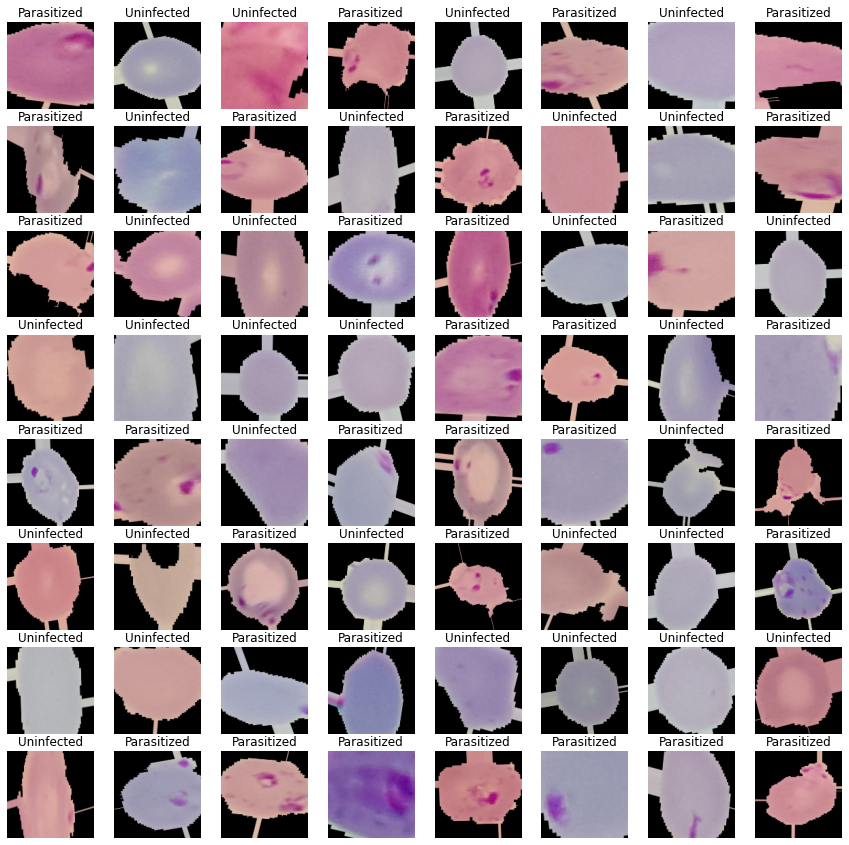

In [3]:
import matplotlib.pyplot as plt
import numpy as np
X, Y = train_generator.__getitem__(0)

classes = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(8, 8,figsize=(15,15))
for x in range(8):
    for y in range(8):
        axes[x][y].imshow((X[x*8 + y]).astype("uint8"))
        class_num = int(np.argmax(Y[x*8 + y]))
        class_name = classes[class_num]
        axes[x][y].title.set_text(class_name)
        axes[x][y].axis('off')

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 2 classes not thousands.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(weights="imagenet"):
    n_classes = len(classes)
    pre_trained_model = EfficientNetB0(include_top=False, weights=weights)

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model

## Training with random weights
We train the model with randomly generated weights as a baseline to compare our pre-trained network against.

In [5]:
model_no_pretrain = create_model(None)
history_no_pretrained = model_no_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/20
302/302 [==============================] - 459s 2s/step - loss: 0.8626 - accuracy: 0.5728 - val_loss: 0.6738 - val_accuracy: 0.5561
Epoch 2/20
302/302 [==============================] - 109s 362ms/step - loss: 0.6648 - accuracy: 0.7143 - val_loss: 0.3875 - val_accuracy: 0.8260
Epoch 3/20
302/302 [==============================] - 108s 356ms/step - loss: 0.4965 - accuracy: 0.8338 - val_loss: 0.9522 - val_accuracy: 0.6447
Epoch 4/20
302/302 [==============================] - 106s 352ms/step - loss: 0.3064 - accuracy: 0.8939 - val_loss: 0.2847 - val_accuracy: 0.9000
Epoch 5/20
302/302 [==============================] - 106s 350ms/step - loss: 0.2725 - accuracy: 0.9075 - val_loss: 0.2396 - val_accuracy: 0.9165
Epoch 6/20
302/302 [==============================] - 203s 673ms/step - loss: 0.2543 - accuracy: 0.9143 - val_loss: 0.2551 - val_accuracy: 0.9198
Epoch 7/20
302/302 [==============================] - 130s 431ms/step - loss: 0.2483 - accuracy: 0.9164 - val_loss: 0.2440 - va

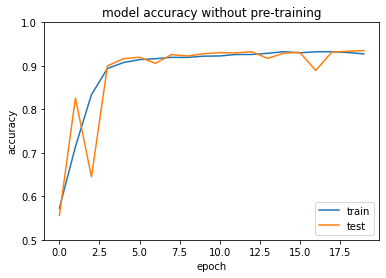

In [15]:
# summarize history for accuracy
plt.plot(history_no_pretrained.history['accuracy'])
plt.plot(history_no_pretrained.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.5,1])
plt.legend(['train', 'test'], loc='lower right')
plt.show()

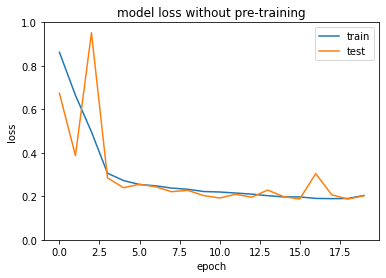

In [14]:
# summarize history for loss
plt.plot(history_no_pretrained.history['loss'])
plt.plot(history_no_pretrained.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## training with pre-trained weights
Next up we load a new model but this time with pretrained weights.
Everything else about the model is exactly the same.

In [8]:
model_with_pretrain = create_model("imagenet")
history_pretrained = model_with_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/20
302/302 [==============================] - 106s 352ms/step - loss: 0.2594 - accuracy: 0.9148 - val_loss: 0.1707 - val_accuracy: 0.9389
Epoch 2/20
302/302 [==============================] - 105s 348ms/step - loss: 0.1715 - accuracy: 0.9380 - val_loss: 0.1593 - val_accuracy: 0.9408
Epoch 3/20
302/302 [==============================] - 110s 364ms/step - loss: 0.1525 - accuracy: 0.9441 - val_loss: 0.1559 - val_accuracy: 0.9460
Epoch 4/20
302/302 [==============================] - 106s 350ms/step - loss: 0.1410 - accuracy: 0.9482 - val_loss: 0.1466 - val_accuracy: 0.9453
Epoch 5/20
302/302 [==============================] - 107s 353ms/step - loss: 0.1457 - accuracy: 0.9469 - val_loss: 0.1487 - val_accuracy: 0.9468
Epoch 6/20
302/302 [==============================] - 107s 355ms/step - loss: 0.1293 - accuracy: 0.9539 - val_loss: 0.2162 - val_accuracy: 0.9164
Epoch 7/20
302/302 [==============================] - 107s 353ms/step - loss: 0.1240 - accuracy: 0.9534 - val_loss: 0.1489 -

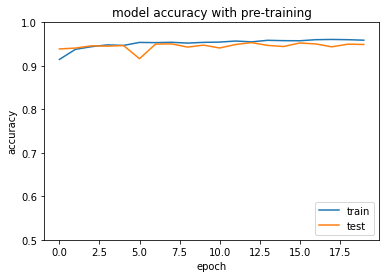

In [13]:
# summarize history for accuracy
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.5,1])
plt.legend(['train', 'test'], loc='lower right')
plt.show()

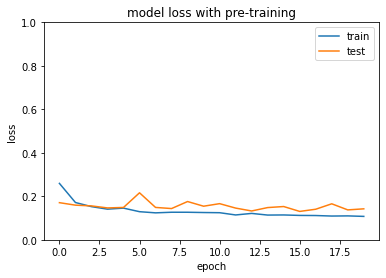

In [16]:
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Conclusion
We can see the pre-trained model being at a better accuracy and loss for both validation and training after 3 epoch compared to 50 epoch if we don't pre-train.

We also see some danger, because the pre-trained model start overfitting way earlier.

But we can see that even when the dataset domains are futher apart transfer learning still has benefits.